# Working with Shapefiles

In [3]:
import os
from osgeo import gdal, ogr
import rasterio

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium
from folium import Choropleth

### Region of Interest
One typical example of shapefiles is to focus our analysis on a Region of Interest

In [4]:
roi_map = folium.Map(location=[-22.73197, -50.6238],  tiles='Mapbox Bright', zoom_start=6)
roi_map.choropleth(geo_data='./data/bra_meso_parana_1.geojson')
roi_map

/usr/lib/python3.4/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Rasterization

In [7]:

def shp_to_tif(fname_raster_ref, fname_shp, fname_shp_rasterized):
    """
    :fname_raster_ref: The reference raster used to understand how we rasterize our vector. (projections etc.)
    :fname_shp: The shapefile we want to rasterize
    """
    # 1. Get usefull info from the reference raster
    raster_ds = gdal.Open(fname_raster_ref, gdal.GA_ReadOnly)
    # Fetch number of rows and columns
    ncol = raster_ds.RasterXSize
    nrow = raster_ds.RasterYSize
    # Fetch projection and extent
    proj = raster_ds.GetProjectionRef()
    ext = raster_ds.GetGeoTransform()
    # close raster
    raster_ds = None
    
    # 2. get info from the shape file we want to rasterize
    driver = ogr.GetDriverByName('KML')
    datasource = driver.Open(fname_shp)
    layer = datasource.GetLayer()
    ###shp_dataset = ogr.Open(fname_shp)
    ###layer = shp_dataset.GetLayerByIndex(0)

    
    # 3. Create the raster dataset
    memory_driver = gdal.GetDriverByName('GTiff')
    out_raster_ds = memory_driver.Create(fname_shp_rasterized, ncol, nrow, 1, gdal.GDT_Byte)

    # Set the ROI image's projection and extent to our input raster's projection and extent
    out_raster_ds.SetProjection(proj)
    out_raster_ds.SetGeoTransform(ext)

    # Fill our output band with the 0 blank, no class label, value
    b = out_raster_ds.GetRasterBand(1)
    #b.Fill(0)
    b.SetNoDataValue(0)

    # Rasterize the shapefile layer to our new dataset
    status = gdal.RasterizeLayer(out_raster_ds,  # output raster
                                 [1],            # band
                                 layer,          # rasterize this layer
                                 burn_values=[1] # burn with value=1
                                 )
    
    # Close dataset
    out_raster_ds = None

    
fname_raster_ref = 'data/rasters_crops/crops_2005.tif'
fname_shp = 'data/shapefiles_brazil_admin/bra_meso_parana_1.kml'
fname_shp_rasterized = 'data/shapefiles_brazil_admin_rasterized/bra_meso_parana_1.tif'
shp_to_tif(fname_raster_ref, fname_shp, fname_shp_rasterized)

### AOI using rasterization

In [18]:
crop_raster = rasterio.open(fname_raster_ref)
ar = crop_raster.read(1)

In [19]:
# read the mask after rasterization
src = rasterio.open(fname_shp_rasterized)
region_mask = src.read(1)

# get the reference image after applying the mask
fname_raster_ref_masked = np.ma.masked_where(region_mask!=1, ar)   # filter out values larger than 5

Text(0.5,1,'Image Masked')

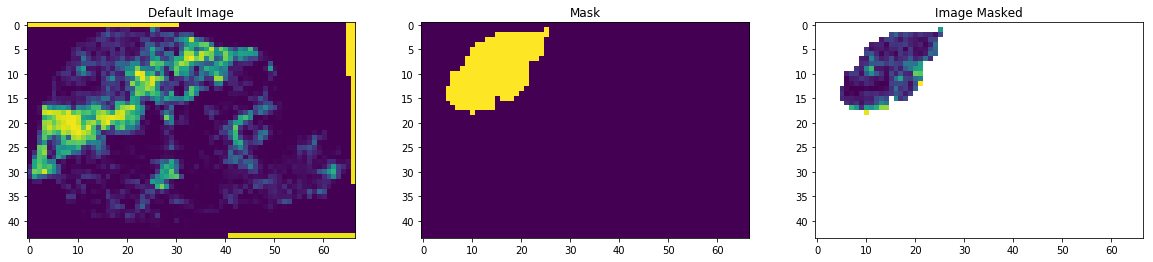

In [20]:
fig = plt.figure(figsize=(20,10))
a = fig.add_subplot(1, 3, 1)
pyplot.imshow(ar)
a.set_title('Default Image')

a = fig.add_subplot(1, 3, 2)
pyplot.imshow(region_mask)
a.set_title('Mask')

a = fig.add_subplot(1, 3, 3)
pyplot.imshow(fname_raster_ref_masked)
a.set_title('Image Masked')


In [21]:
# Focus on the Are of Interest and calculate necessary info
fname_raster_ref_masked.sum()

387174.12